- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [1]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True
    
if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python
    !git pull


- enable module autoreload and fix an import bug

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

%load_ext autoreload
%autoreload 2


import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [3]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

2022-05-17 17:11:42.801945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaxo7/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-17 17:11:42.801985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


- load the dataset
- and ceate image slices

- slice each image to small samples of size 188*188
- imgs -> rgb image
- mask -> mask
- edge -> edge_mask

load_data before preprocessing:
image: (1944, 2592, 3)
mask : (1944, 2592)
edge : (1944, 2592)
load_data after preprocessing:
image: (2344, 2992, 3)
mask : (2344, 2992)
edge : (2344, 2992)
test_chips:
img_chips shape : (1302, 188, 188, 3)
mask_chips shape : (1302, 100, 100, 1)
edge_chips shape : (1302, 100, 100, 1)


TypeError: Invalid shape (1302, 188, 188, 3) for image data

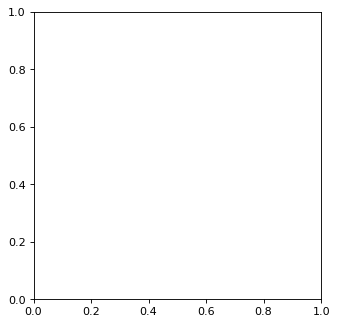

In [11]:
train_img_files = glob.glob('data/train/*.jpg')
test_img_files = glob.glob('data/test/*.jpg')

#train = model.generate_train_dataset(train_img_files)

#train_generator = model.generate_train_dataset(train_img_files)

#train_set = model.generate_train_dataset_tf(train_img_files)


#test_img_chips, test_mask_chips, test_edge_chips = model.generate_test_dataset(test_img_files)

train_img_chips, train_mask_chips, train_edge_chips = model.generate_test_dataset(test_img_files)

len(train_img_chips)

#test_set = tf.data.Dataset.from_tensor_slices((test_img_chips, (test_mask_chips, test_edge_chips)))


fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = fig.add_subplot(2, 3, 1)
ax.imshow(train_img_chips)
ax = fig.add_subplot(2, 3, 2)
ax.imshow(np.squeeze(train_mask_chips))
ax = fig.add_subplot(2, 3, 3)
ax.imshow(np.squeeze(train_edge_chips))


- Profiler cell

In [20]:
import IPython.core
IPython.core.page = print

%lprun -f model.generate_train_dataset_tf model.generate_train_dataset_tf(train_img_files)

mask :  (array([0, 1, 2], dtype=uint8), array([4324013, 2508192,  181043]))
edge :  (array([0, 1, 2], dtype=uint8), array([6621817,  362288,   29143]))
mask :  (2344, 2992)
edge :  (2344, 2992)
img :  (2344, 2992, 3)


Timer unit: 1e-06 s

Total time: 7.60964 s
File: /home/zaxo7/WorkSpace/DEEP LEARNING/MY-U-NET/scripts/model.py
Function: generate_train_dataset_tf at line 206

Line #      Hits         Time  Per Hit   % Time  Line Contents
   206                                           def generate_train_dataset_tf(img_files):
   207         1    7412165.0 7412165.0     97.4          imgs, mask, edge = data.load_data(img_files)
   208                                                   
   209         1      84611.0  84611.0      1.1          print(f"mask :  {np.unique(mask[0], return_counts=True)}")
   210         1      85990.0  85990.0      1.1          print(f"edge :  {np.unique(edge[0], return_counts=True)}")
   211                                                   
   212         1          9.0      9.0      0.0          print(f"mask :  {mask[0].shape}")
   213         1          7.0      7.0      0.0          print(f"edge :  {edge[0].shape}")
   214         1          7.0      7.0      0.0      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mask :  (array([0, 1, 2], dtype=uint8), array([4324013, 2508192,  181043]))
edge :  (array([0, 1, 2], dtype=uint8), array([6621817,  362288,   29143]))
mask :  (2344, 2992)
edge :  (2344, 2992)
img :  (2344, 2992, 3)


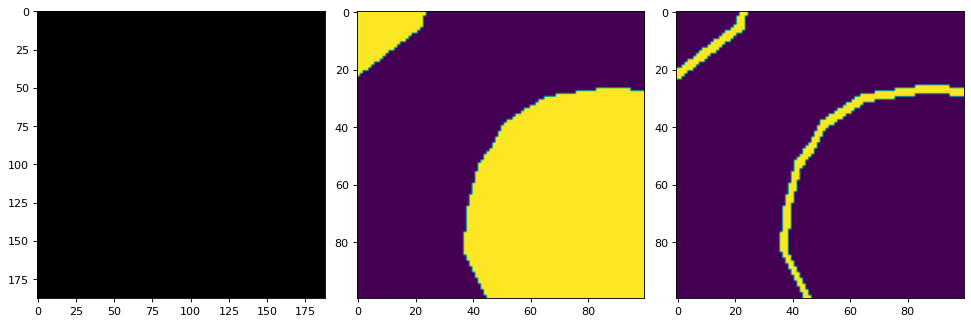

In [4]:
train_generator = model.generate_train_dataset(train_img_files)

train_img_chips, (train_mask_chips, train_edge_chips) =  next(train_generator)

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = fig.add_subplot(2, 3, 1)
ax.imshow(train_img_chips)
ax = fig.add_subplot(2, 3, 2)
ax.imshow(np.squeeze(train_mask_chips))
ax = fig.add_subplot(2, 3, 3)
ax.imshow(np.squeeze(train_edge_chips))

- create the model and compile it

In [5]:
unet = model.get_do_unet(compile = False)

unet.compile(optimizer="adam",
             loss=model.tversky_loss_b,
             loss_weights=[0.3, 0.7],
             metrics={'mask': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'], 
                      'edge': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc']})

unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 188, 188, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 186, 186, 96  2688        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 186, 186, 96  384        ['conv2d[0][0]']                 
 alization)                     )                                                             

- model parameters

In [32]:
_batch_size = 8
_epochs = 5
_workers = 8
_model_name = 'tversky_b_5'
images_per_epoch = 1000
train_steps = images_per_epoch//_batch_size
validation_steps = len(test_img_files)//_batch_size

Train = True

- load weights

In [ ]:
unet.load_weights(f"models/{_model_name}_best.h5")

- Train the model

In [ ]:
if Train:
    history = unet.fit(train_set.batch(_batch_size), 
            epochs=_epochs, 
            validation_data=test_set.batch(_batch_size), 
            steps_per_epoch=train_steps,
            max_queue_size=2*_workers,
            use_multiprocessing=_useMultiProcessing,
            workers=_workers,
            verbose=1,
            callbacks=model.get_callbacks(_model_name))

- save the training log 

In [29]:
#save the training log into a file
import json
my_dict = {'a':11,'b':22,'c':33}
with open(f"models/{_model_name}_log.json", "a+") as fp:
    json.dump(history.history,fp)

# Opening JSON file
with open(f"models/{_model_name}_log.json") as fp:
  # returns JSON object as
  # a dictionary
  loaded_hist = json.load(fp)

In [14]:
rand_index = np.random.randint(0, len(test_img_chips), 1)[0]
img = test_img_chips[rand_index]
mask = np.squeeze(test_mask_chips[rand_index])
edge = np.squeeze(test_edge_chips[rand_index])


img = np.array([np.squeeze(img)])

prediction = unet.predict(img)

prediction = np.squeeze(prediction)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


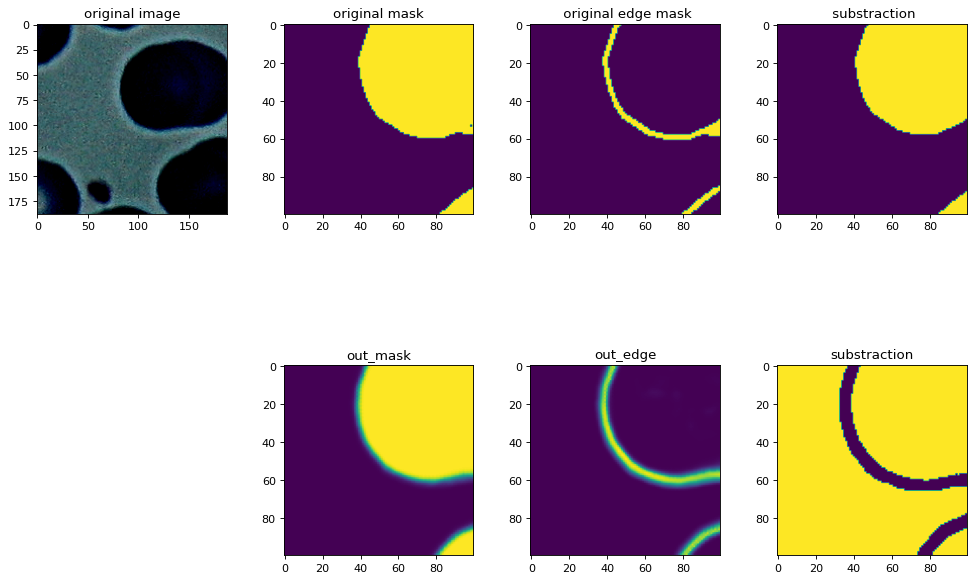

In [16]:
fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original image")
ax.imshow(img[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original mask")
ax.imshow(mask)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" original edge mask")
ax.imshow(edge)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" substraction")
ax.imshow((mask - edge) > 0)


fig_num = fig_num + 2
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_mask")
ax.imshow(prediction[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_edge")
ax.imshow(prediction[1])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("substraction")
ax.imshow((prediction[0] - prediction[1]) > 0)




- predict full image

In [ ]:
images, masks, edges = model.predictFullImage(unet,
                          data.load_data_na(test_img_files, RGB=True, clahe=True),
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)

In [ ]:
data.plot_ime(images,
              masks,
              edges,
              figSize=(25,15))

## model training data plot

In [ ]:
hist = history.history

lines = 4
columns = 3

fig = plt.figure(figsize=(20, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask accuracy")
ax.plot(hist['mask_acc'], label="Training")
ax.plot(hist['val_mask_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge mask accuracy")
ax.plot(hist['edge_acc'], label="Training")
ax.plot(hist['val_edge_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 2
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask loss")
ax.plot(hist['mask_loss'], label="Training")
ax.plot(hist['val_mask_loss'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge loss")
ax.plot(hist['edge_loss'], label="Training")
ax.plot(hist['val_edge_loss'], label="Validation")
ax.legend()

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("global loss")
ax.plot(hist['loss'], label="Training")
ax.plot(hist['val_loss'], label="Validation")
ax.legend()


fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask metrics")
ax.plot(hist['mask_dsc'], label="dsc")
ax.plot(hist['mask_mean_iou'], label="mean iou")
ax.plot(hist['mask_tversky'], label="tversky")
ax.plot(hist['mask_acc'], label="accuracy")

ax.set_title("mask metrics")
ax.plot(hist['val_mask_dsc'], label="val_dsc")
ax.plot(hist['val_mask_mean_iou'], label="val_mean iou")
ax.plot(hist['val_mask_tversky'], label="val_tversky")
ax.plot(hist['val_mask_acc'], label="val_accuracy")

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge metrics")
ax.plot(hist['edge_dsc'], label="dsc")
ax.plot(hist['edge_mean_iou'], label="mean iou")
ax.plot(hist['edge_tversky'], label="tversky")
ax.plot(hist['edge_acc'], label="accuracy")

ax.set_title("edge metrics")
ax.plot(hist['val_edge_dsc'], label="val_dsc")
ax.plot(hist['val_edge_mean_iou'], label="val_mean iou")
ax.plot(hist['val_edge_tversky'], label="val_tversky")
ax.plot(hist['val_edge_acc'], label="val_accuracy")
ax.legend()

## For Debugging
- show in between layers output

In [17]:
ind = np.random.randint(0, 32, 1)[0]

_pool1 = pool1[:-1,:-1,ind]
_pool2 = pool2[:-1,:-1,ind]
_pool3 = pool3[:-1,:-1,ind]
_down4 = down4[:-1,:-1,ind]
_up1 = up1[:-1,:-1,ind]
_up2 = up2[:-1,:-1,ind]
_up3 = up3[:-1,:-1,ind]

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_mask")
ax.imshow(out_mask)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_edge")
ax.imshow(out_edge)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool1")
ax.imshow(_pool1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool2")
ax.imshow(_pool2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool3")
ax.imshow(_pool3)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("down4")
ax.imshow(_down4)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up1")
ax.imshow(_up1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up2")
ax.imshow(_up2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up3")
ax.imshow(_up3)

NameError: name 'pool1' is not defined

- function to plot and array of images of shape (width, height, n_images)

In [ ]:
def picshow(img, title):
    num = img.shape[2]
    imgs_per_line = 4
    ax = num//imgs_per_line + 1
    ay = imgs_per_line
    fig =plt.figure(figsize=(30, num//imgs_per_line * 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(1,num + 1):
        sub = fig.add_subplot(ax,ay,i)
        sub.set_title(f"{title} {i}")
        sub.imshow(img[:-1,:-1,i - 1])
    plt.show()
    



In [ ]:
picshow(pool1, 'pool1 ')
picshow(pool2, 'pool2 ')
picshow(pool3, 'pool3 ')
picshow(down4, 'down4 ')
picshow(up1, 'up1 ')
picshow(up2, 'up2 ')
picshow(up3, 'up3 ')